In [1]:
import pygame
import random
import time
import numpy as np
import matplotlib.pyplot as plt

class RandomPlayer:
    def __init__(self):
        pass
    
    def move(self, possible_moves):
        return random.choice(possible_moves)

class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha    # Learning rate
        self.gamma = gamma    # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}     # Q-value table

    def get_action(self, state, possible_actions):
        if len(possible_actions) == 0:
            return None  # No possible actions
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return np.random.choice(possible_actions)
        else:
            # Exploit: choose the action with the highest Q-value
            q_values = [self.q_table.get((state, action), 0) for action in possible_actions]
            max_q_value = max(q_values)
            return np.random.choice([action for action, q in zip(possible_actions, q_values) if q == max_q_value])

    def update_q_table(self, state, action, reward, next_state, next_action):
        # Update the Q-table using the SARSA formula
        current_q = self.q_table.get((state, action), 0)
        next_q = self.q_table.get((next_state, next_action), 0)
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[(state, action)] = new_q

class TicTacToe:
    def __init__(self, training=False):
        self.training = training
        self.win_history = []  # Track win history
        self.board = [' '] * 9
        self.agent = SARSAAgent()
        self.done = False

        if not self.training:
            pygame.init()
            self.ttt = pygame.display.set_mode((225, 250))
            pygame.display.set_caption('Tic-Tac-Toe')
            self.surface = pygame.Surface(self.ttt.get_size())
            self.surface.convert()
            self.surface.fill((250, 250, 250))
            self.draw_board()

    def reset(self):
        """Reset the game state."""
        self.board = [' '] * 9
        if not self.training:
            self.human_turn = random.choice([True, False])
            self.surface.fill((250, 250, 250))
            self.draw_board()

    def get_state(self):
        """Convert the board state to a string."""
        return ''.join(self.board)

    def step(self, isX, move):
        """Make the next move and return the reward."""
        ch = 'X' if isX else 'O'
        if self.board[move - 1] != ' ':  # Invalid move
            return -5, True

        self.board[move - 1] = ch
        reward, done = self.evaluate(ch)
        return reward, done

    def draw_board(self):
        """Draw the game board."""
        for i in range(1, 3):
            pygame.draw.line(self.surface, (0, 0, 0), (75 * i, 0), (75 * i, 225), 2)
            pygame.draw.line(self.surface, (0, 0, 0), (0, 75 * i), (225, 75 * i), 2)

    def evaluate(self, ch):
        """Evaluate the game state for a given player."""
        for i in range(3):
            if ch == self.board[i * 3] == self.board[i * 3 + 1] == self.board[i * 3 + 2]:
                return 1.0, True
            if ch == self.board[i] == self.board[i + 3] == self.board[i + 6]:
                return 1.0, True
        if ch == self.board[0] == self.board[4] == self.board[8] or ch == self.board[2] == self.board[4] == self.board[6]:
            return 1.0, True

        if not any(c == ' ' for c in self.board):
            return 0.5, True  # Draw

        return 0.0, False

    def possible_moves(self):
        """Return remaining possible moves."""
        return [moves + 1 for moves, v in enumerate(self.board) if v == ' ']

    def draw_move(self, pos, isX):
        """Draw the move on the window."""
        row = (pos - 1) // 3
        col = (pos - 1) % 3
        centerX = (col * 75) + 32
        centerY = (row * 75) + 32

        reward, done = self.step(isX, pos)
        font = pygame.font.Font(None, 24)
        text_color = (10, 10, 10)

        if reward == -5:  # Invalid move
            text = font.render('Invalid move!', 1, text_color)
            self.surface.fill((250, 250, 250), (0, 300, 300, 25))
            self.surface.blit(text, (10, 230))
            return reward, done

        text = font.render('X' if isX else 'O', 1, text_color)
        self.surface.fill((250, 250, 250), (0, 300, 300, 25))
        self.surface.blit(text, (centerX, centerY))
        
        if isX:
            self.board[pos - 1] = 'X'
            if reward == 1:
                text = font.render('Human won!', 1, text_color)
                self.surface.blit(text, (10, 230))
        else:
            self.board[pos - 1] = 'O'
            if reward == 1:
                text = font.render('Computer won!', 1, text_color)
                self.surface.blit(text, (10, 230))

        if reward == 0.5:
            text = font.render('Draw Game!', 1, text_color)
            self.surface.fill((250, 250, 250), (0, 300, 300, 25))
            self.surface.blit(text, (10, 230))

        return reward, done

    def mouse_click(self):
        """Get the mouse click position."""
        (mouseX, mouseY) = pygame.mouse.get_pos()
        row = mouseY // 75
        col = mouseX // 75
        return row * 3 + col + 1

    def update_state(self, isX):
        """Update the game state based on player move."""
        pos = self.mouse_click()
        reward, done = self.draw_move(pos, isX)
        return reward, done

    def show_board(self):
        """Show the current game board."""
        self.ttt.blit(self.surface, (0, 0))
        pygame.display.flip()

    def start_training(self, player1, player2):
        """Begin training with two Q-learning players."""
        if isinstance(player1, SARSAAgent) and isinstance(player2, SARSAAgent):
            self.training = True
            self.player1 = player1
            self.player2 = player2

    def train(self, iterations):
       """Train the player using the SARSA algorithm."""
       for i in range(iterations):
           print("Training iteration:", i)
           self.reset()
           done = False
           isX = True  # Player X starts
           state = self.get_state()
           action = self.agent.get_action(state, self.possible_moves())
    
           while not done:
               # Perform action and get reward
               if action is None:  # No possible actions, break the loop
                   break
               
               reward, done = self.step(isX, action)
               next_state = self.get_state()
               next_action = self.agent.get_action(next_state, self.possible_moves())
    
               # Update Q values
               if next_action is None:  # If there are no possible actions, break
                   break
               
               self.agent.update_q_table(state, action, reward, next_state, next_action)
    
               # Update state and action
               state = next_state
               action = next_action
               isX = not isX
    
           self.win_history.append(reward)
           print("End of Game:", reward)
           time.sleep(0.5)
    
    def moving_average(self, data, window_size):
        """Calculate the moving average of the data."""
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    def plot_results(self):
        """Plot the training results with a moving average."""
        rewards = np.array(self.win_history)
        mean_rewards = self.moving_average(rewards, window_size=50)

        plt.figure(figsize=(10, 5))
        plt.plot(rewards, label='Rewards', alpha=0.5)
        plt.plot(np.arange(49, len(rewards)), mean_rewards, label='Mean of Last 50 Rewards', color='orange')
        plt.xlabel('Game')
        plt.ylabel('Reward')
        plt.title('Monte Carlo Training Results')
        plt.legend()
        plt.grid()
        plt.show()


pygame 2.5.2 (SDL 2.28.3, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
game = TicTacToe(training=True)
game.train(500)


Training iteration: 0
End of Game: 0.5
Training iteration: 1
End of Game: 1.0
Training iteration: 2
End of Game: 1.0
Training iteration: 3
End of Game: 1.0
Training iteration: 4
End of Game: 1.0
Training iteration: 5
End of Game: 1.0
Training iteration: 6
End of Game: 1.0
Training iteration: 7
End of Game: 1.0
Training iteration: 8
End of Game: 1.0
Training iteration: 9
End of Game: 1.0
Training iteration: 10
End of Game: 1.0
Training iteration: 11
End of Game: 1.0
Training iteration: 12
End of Game: 1.0
Training iteration: 13
End of Game: 1.0
Training iteration: 14
End of Game: 1.0
Training iteration: 15
End of Game: 0.5
Training iteration: 16
End of Game: 1.0
Training iteration: 17
End of Game: 1.0
Training iteration: 18
End of Game: 0.5
Training iteration: 19
End of Game: 1.0
Training iteration: 20
End of Game: 1.0
Training iteration: 21
End of Game: 1.0
Training iteration: 22
End of Game: 0.5
Training iteration: 23
End of Game: 1.0
Training iteration: 24
End of Game: 1.0
Training i

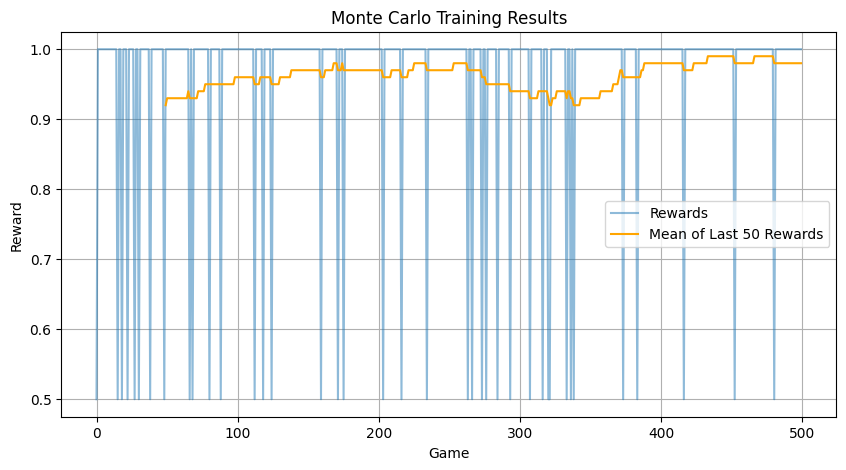

In [4]:
game.plot_results()